In [1]:
%cd ../..

/Users/stefanomartire/GitHub/OBIWAN_main


In [2]:
from results.MD import MD_utils
from results.MD import MD_engine
from architectures import net_utils
import tensorflow as tf

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Settings

## MD settings

In [ ]:
chosen_dtype = 'float32'
tf.keras.backend.set_floatx(chosen_dtype)
tf.keras.mixed_precision.set_global_policy(chosen_dtype)

settings = MD_utils.Settings()
settings.dt = 0.001    # time step [ps]
settings.seed = 777
settings.int_type = 'vv_gromacs'
settings.strideSaving = 10        # every strideSaving steps we save the coordinates and energies

input_file = "results/MD/inputs/K3T_angle.sdf"

# settings.pdbFileName = "results/MD/mdTraj.pdb"
settings.xyzFileName = "results/MD/outputs/K3T_angle_traj_1fs.xyz"

## System settings

Inputs must be in **Angstrom**

In [ ]:
numberAtoms, coords, types, masses = MD_utils.readSDFile(input_file)    # in Angstrom
box_sizes = tf.constant([1000.0,1000.0,1000.0], dtype=chosen_dtype)     # in Angstrom

coords = tf.cast(coords/10.0, dtype=chosen_dtype)           # convert Angstrom to nm for the MD
box_sizes = tf.cast(box_sizes/10.0, dtype=chosen_dtype)
masses = tf.expand_dims(masses, axis=-1)
masses = tf.tile(masses, [1, 3])
masses = tf.cast(masses, dtype=chosen_dtype)

# NNP

In [ ]:
obiwan = net_utils.getModel(
                        model_name="obiwan",
                        max_molecule_size=44,
                        dynamic_mode=True,
                        weights="results/models/obiwan_ani1Uani2_FH_VL_2.404",
                    )

@tf.function
def energy_tf(coordinates, box_sizes, species):
    # Convert nm to Angstrom for Obiwan
    coordinates = coordinates * 10.
    box_sizes = box_sizes * 10.
    # Add batch dimension
    coordinates = tf.expand_dims(coordinates, axis=0)
    species = tf.expand_dims(species, axis=0)
    box_sizes = tf.expand_dims(box_sizes, axis=0)
    # Compute energy and remove batch dimension
    energy = obiwan([coordinates, species, box_sizes])
    energy = tf.squeeze(energy)
    # Convert Ha to kJ/mol for saving
    energy = energy * 2625.5
    return energy

# Setup and run

In [ ]:
sys = MD_utils.System(chosen_dtype)
sys.getNNSys(numberAtoms, box_sizes, masses, coords, energy_tf, types)
md = MD_engine.MolecularDynamics(settings, sys, chosen_dtype, wrapping=False)

md.initState()

In [ ]:
eta = 1e-6
maxIt = 1_000_000
stopCond = ["max_force", 0.6]      # the real condition
md.minimize(eta, stopCond, maxIt)

In [ ]:
md.settings.T = tf.constant(100.0, dtype=chosen_dtype)
numSteps = 1_000            # 1 ps
md.run(numSteps)

md.settings.T = tf.constant(200.0, dtype=chosen_dtype)
md.run(numSteps, append_results=True)

md.settings.T = tf.constant(300.0, dtype=chosen_dtype)
numSteps = 1_000_000        # 1 ns
md.run(numSteps, append_results=True)

# Visualization

In [4]:
xyz, typ, Na, energies = MD_utils.readXYZ("results/MD/outputs/K3T_angle_traj_1fs.xyz")

In [5]:
energies = np.array(energies, dtype=np.float32)
energies = energies[200:]   # remove temperature equilibration

In [6]:
energies = energies[-2500:]     # last 25 ps (we saved every 10 steps)

steps = np.arange(0, len(energies), dtype=np.float32)
steps /= 100    # convert to ps

In [7]:
energies = energies - np.mean(energies)     # center around 0
energies /= 4.184       # convert to kcal/mol

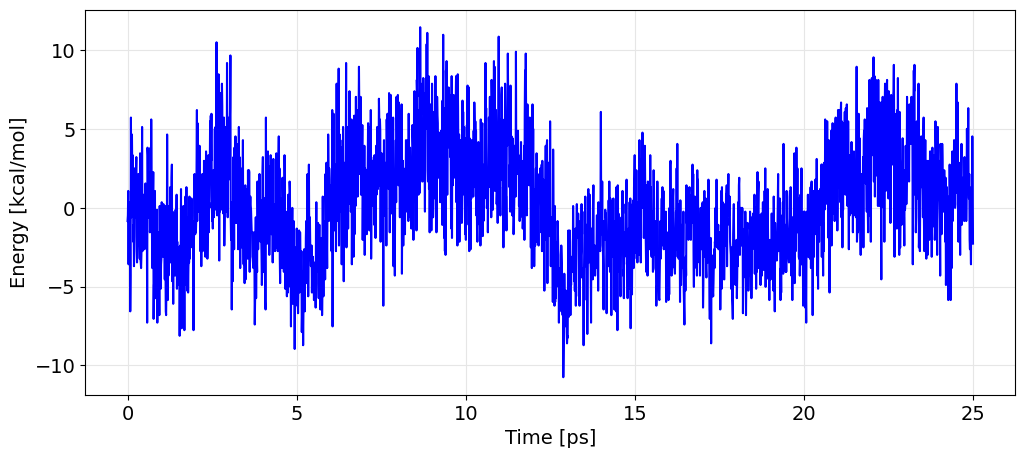

In [8]:
# set the size of all the fonts to 14
plt.rc('font', size=14)

plt.plot(steps, energies, color='blue')
plt.xlabel("Time [ps]")
plt.ylabel("Energy [kcal/mol]")

plt.grid(color='0.9')

fig = plt.gcf()
fig.set_size_inches(12, 5)

# test

In [9]:
filename = "results/MD/outputs/ANI_99_traj_1fs.xyz"

In [10]:
xyz, typ, Na, energies = MD_utils.readXYZ(filename)

In [11]:
energies = np.array(energies, dtype=np.float32)

steps = np.arange(0, len(energies), dtype=np.float32)
steps /= 100    # convert to ps

energies = energies - np.mean(energies)     # center around 0
energies /= 4.184       # convert to kcal/mol

print(f"Number of steps: {len(energies)*10}")

Number of steps: 1000


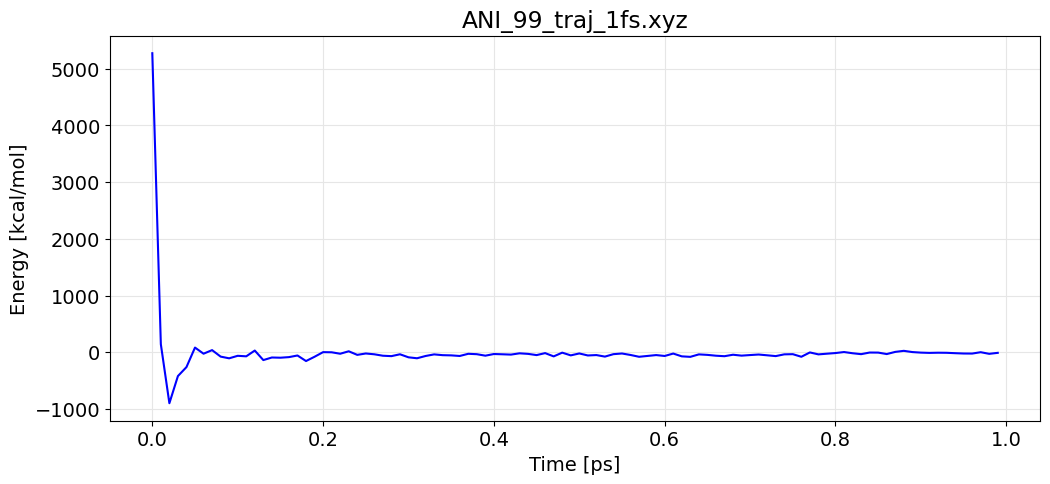

In [12]:
# set the size of all the fonts to 14
plt.rc('font', size=14)

plt.plot(steps, energies, color='blue')
plt.xlabel("Time [ps]")
plt.ylabel("Energy [kcal/mol]")

plt.grid(color='0.9')

plt.title(f"{filename.split('/')[-1]}")

fig = plt.gcf()
fig.set_size_inches(12, 5)